In [1]:

import gzip
from collections import defaultdict
import math
import operator
import scipy.optimize
from sklearn import svm
import numpy as np
import string
import random
import string
from sklearn import linear_model
import warnings
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import scipy
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import numpy as np
class Utilites:
    def readGz(path):
        for l in gzip.open(path, 'rt',encoding='utf-8'):
            yield eval(l)

    def punctuations():
        return set(string.punctuation)

    def readCSV(path):
        f = gzip.open(path, 'rt')
        f.readline()
        for l in f:
            u, b, r = l.strip().split(',')
            r = int(r)
            yield u, b, r

    def Cosine(x1, x2):
        numer = 0
        norm1 = 0
        norm2 = 0
        for a1, a2 in zip(x1, x2):
            numer += a1*a2
            norm1 += a1**2
            norm2 += a2**2
        if norm1*norm2:
            return numer / math.sqrt(norm1*norm2)
        return 0

    def calcAcc(y, predY):
        assert( len(y) == len(predY))
        correct = np.array(y) == np.array(predY)
        return sum(correct) / len(correct)
    



In [2]:
users_review_data = []
reviews_data = []
users_items_data = []
items_data = []
bundle_data = []

for d in Utilites.readGz("user_reviews.json.gz"):
    users_review_data.append(d)

#for d in Utilites.readGz("/work/steam_reviews.json.gz"):
    #reviews_data.append(d)

for d in Utilites.readGz("users_items.json.gz"):
    users_items_data.append(d)

for d in Utilites.readGz("steam_games.json.gz"):
    items_data.append(d)

for d in Utilites.readGz("bundle_data.json.gz"):
    bundle_data.append(d)

In [3]:
users_items_train = []
users_items_validation = []
users_items_test = []
users_per_item_train = defaultdict(set)
items_per_user_train = defaultdict(set)
times_per_game = defaultdict(list)

for d in users_items_data:
    games_played_by_user = [ game for game in d['items'] if game['playtime_forever'] > 0]
    random.shuffle(games_played_by_user)

    for i in range(len(games_played_by_user)):
        times_per_game[games_played_by_user[i]['item_id']].append(
            games_played_by_user[i]['playtime_forever'])

        if(i < len(games_played_by_user) * 0.6):
            users_items_train.append((d['user_id'], games_played_by_user[i]))
            items_per_user_train[d['user_id']].add((games_played_by_user[i]['item_id'],games_played_by_user[i]['playtime_forever'],games_played_by_user[i]['playtime_2weeks']))
            users_per_item_train[games_played_by_user[i]['item_id']].add((d['user_id'],games_played_by_user[i]['playtime_forever'],games_played_by_user[i]['playtime_2weeks']))

        elif(i < len(games_played_by_user) * 0.8):
            users_items_validation.append((d['user_id'], games_played_by_user[i]))
        else:
            users_items_test.append((d['user_id'], games_played_by_user[i]))

games = defaultdict()
for d in items_data:
    if(d.__contains__('id')):
        games[d['id']] = d
    else:
        if(d['url'].split('/')[-1] != ''):
            games[d['url'].split('/')[-1]] = d


In [4]:
def prep_data(data):
    x =[]
    y = []
    for user,gameInfo in data:
        if(gameInfo['playtime_forever'] <= 45): y.append(0)
        elif(gameInfo['playtime_forever'] <= 220): y.append(1)
        elif(gameInfo['playtime_forever'] <= 840): y.append(2)
        else: y.append(3)
        x.append((user,gameInfo['item_id']))
    return x, y

#### Visualize the distribution of data (time played by player)

Text(0, 0.5, 'Number of players')

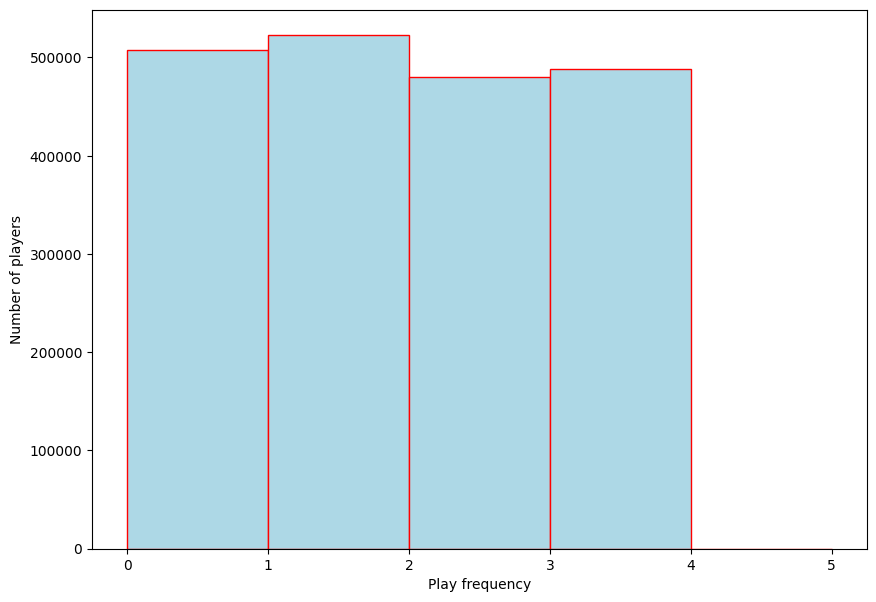

In [5]:
trainX, trainY = prep_data(users_items_train)
valX, valY = prep_data(users_items_validation)
testX, testY = prep_data(users_items_test)
a = np.array(trainY)
plot, ax= plt.subplots(figsize =(10, 7))
threshold = []
for i in range(0,6,1):
    threshold.append(i)
plt.hist(a, bins=threshold,color = "lightblue", ec="red")
ax.set_xlabel("Play frequency")
ax.set_ylabel("Number of players")


In [6]:
timesPerGameMean = {}
timesPerGameMedian = {}
timesPerCategory = defaultdict(list)
for game in times_per_game:
    timesPerGameMean[game] = np.mean(times_per_game[game])
    timesPerGameMedian[game] = np.median(times_per_game[game])
    if(game in games and 'genres' in games[game]):
        genres = games[game]['genres']
        for gameCategory in genres:
            timesPerCategory[gameCategory] += times_per_game[game]

In [7]:
timesPerTag = defaultdict(list)
for game in times_per_game:
    if(game in games and 'tags' in games[game]):
        genres = games[game]['tags']
        for gameCategory in genres:
            if(len(times_per_game) > 0):
                timesPerTag[gameCategory] += times_per_game[game]

In [8]:
timesPerCategoryMean = {}
timesPerCategoryMedian = {}
timesPerTagMean = {}
timesPerTageMedian = {}

for cat in timesPerCategory:
    timesPerCategoryMean[cat] = np.mean([ x for x in timesPerCategory[cat]])
    timesPerCategoryMedian[cat] = np.median([ x for x in timesPerCategory[cat]])

In [9]:
for tag in timesPerTag:
    timesPerTagMean[tag] = np.mean([ x for x in timesPerTag[tag]])
    timesPerTageMedian[tag] = np.median([ x for x in timesPerTag[tag]])

In [10]:
sortTagMean = sorted(timesPerTagMean.items(), key=lambda x: x[1], reverse=True)
sortTagMedian = sorted(timesPerTageMedian.items(), key=lambda x: x[1], reverse=True)


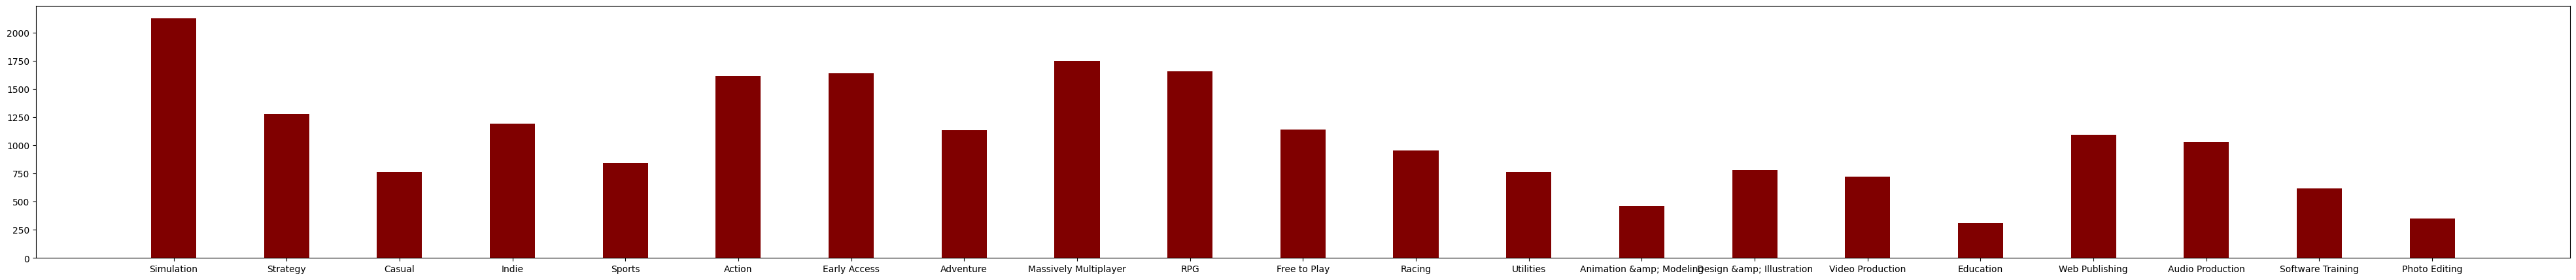

In [11]:
courses = list(timesPerCategoryMean.keys())
values = list(timesPerCategoryMean.values())
fig = plt.figure(figsize = (50, 5))

# creating the bar plot
plt.bar(courses, values, color ='maroon',
        width = 0.4)
 
plt.show()  

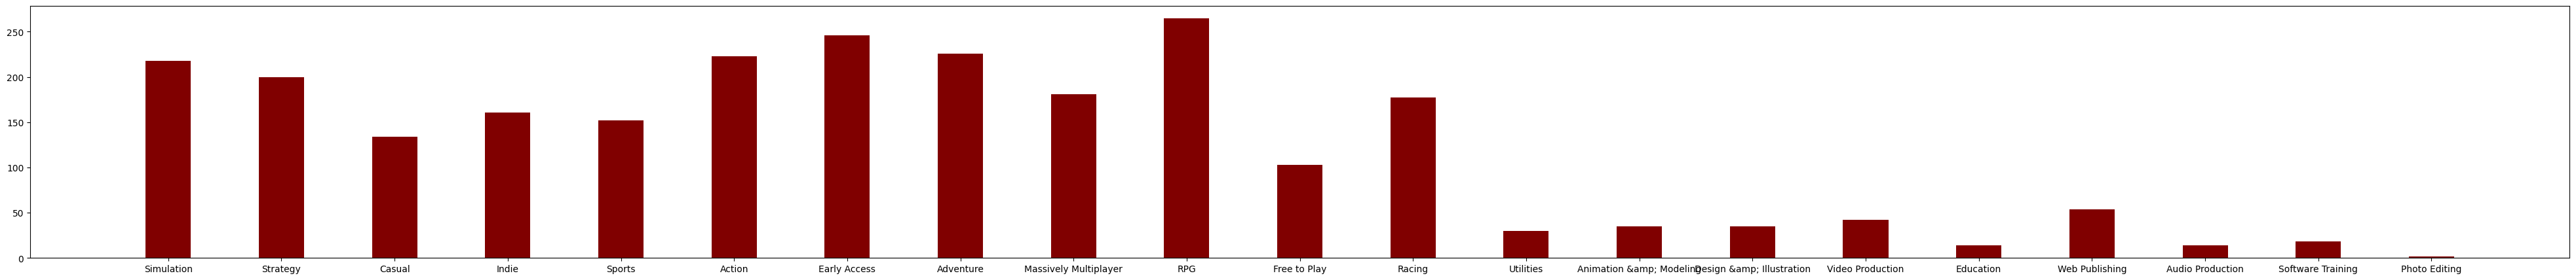

In [12]:
courses = list(timesPerCategoryMedian.keys())
values = list(timesPerCategoryMedian.values())
fig = plt.figure(figsize = (50, 5))

# creating the bar plot
plt.bar(courses, values, color ='maroon',
        width = 0.4)
 
plt.show()  

In [13]:
def evalModel(model, dataX, dataY, args=[]):
    predY = model(dataX,args)
    acc = Utilites.calcAcc(predY, dataY)
    return acc

##### Trivial Predictor (always predict that a user never plays the game)

In [14]:
# Always predict that a user will never play a game
def modelPredTrivial(data, args={}):
    y_pred = [0] * len(data)
    return y_pred

##### Predict based on popularity of game (distance to mean time played)

In [15]:
def modelPredPopularityDifference(data,args={'mode':"mean"}):
    y_pred = []
    threshold = np.array([45,220,840,1460])
    for user, item in data:
        if(args['mode'] == "mean"):
            avg_time = timesPerGameMean[item]
        else:
            avg_time = timesPerGameMedian[item]
        diff = np.abs(threshold - avg_time)
        y_pred.append(np.argmin(diff))
    return y_pred

##### Predict based on popularity of game (based on paritcular threashold from mean time played)


In [16]:
def modelPredPopularityThreashold(data, args={'mode':"mean"}):
    y_pred = []
    for user, item in data:
        if(args['mode'] == "mean"):
            avg_time = timesPerGameMean[item]
        else:
            avg_time = timesPerGameMedian[item]
        if(avg_time <= 45): y_pred.append(0)
        elif(avg_time <= 220): y_pred.append(1)
        elif(avg_time<= 840): y_pred.append(2)
        else: y_pred.append(3)
    return y_pred

In [17]:
def modelPredByPlayerTime(data, args={'mode':"median"}):
    y_pred = []
    for user, item in data:
        avg_time = np.median([playtime for gameId, playtime, _ in  items_per_user_train[user]])
        if(avg_time <= 45): y_pred.append(0)
        elif(avg_time <= 220): y_pred.append(1)
        elif(avg_time<= 840): y_pred.append(2)
        else: y_pred.append(2)
    return y_pred

### Baseline prediction

In [18]:
args = {"mode":"mean"}
# Predict based on popularity
print(f'Popularity predictor(difference) acc: {evalModel(modelPredPopularityDifference,testX,testY,args)}')

# Predict based on popularity
print(f'Popularity predictor(threashold) acc: {evalModel(modelPredPopularityThreashold,testX,testY,args)}')

print(f'Player Popularity predictor(threashold) acc: {evalModel(modelPredByPlayerTime,testX,testY,args)}')

# Predict that a player that bought the game will never play it
print(f'Trivial predictor acc: {evalModel(modelPredTrivial,testX,testY,args)}')

Popularity predictor(difference) acc: 0.4124727432697912
Popularity predictor(threashold) acc: 0.38332531314469215
Trivial predictor acc: 0.25347448865341826


In [19]:
args = {"mode":"median"}

# Predict based on popularity
print(f'Popularity predictor(difference) acc: {evalModel(modelPredPopularityDifference,testX,testY,args)}')

# Predict based on popularity
print(f'Popularity predictor(threashold) acc: {evalModel(modelPredPopularityThreashold,testX,testY,args)}')

print(f'Player Popularity predictor(threashold) acc: {evalModel(modelPredByPlayerTime,testX,testY,args)}')

# Predict that a player that bought the game will never play it
print(f'Trivial predictor acc: {evalModel(modelPredTrivial,testX,testY,args)}')


Popularity predictor(difference) acc: 0.39367691503840957
Popularity predictor(threashold) acc: 0.42609435871048074
Trivial predictor acc: 0.25347448865341826


Popularity predictor(threashold) acc: 0.29289411286390615


### Classifier prediction

In [21]:
all_genres = np.array(list(timesPerCategory.keys()))
genres = {}

In [22]:
for x in range(len(all_genres)):
    genres[all_genres[x]] = x

In [23]:
size = len(genres)
def oneHotEncodeCat(data):
    encode = np.zeros(size)
    for x in data:
        encode[genres[x]] = 1
    return encode

In [24]:
def prep_features(data):
    user = data[0]
    item = data[1]
    ## Genres of item
    if(item in games and 'genres' in games[item]):
        feat = oneHotEncodeCat(games[item]['genres'])
    else:
        feat = np.zeros(size)
    # Gloabal mean playtime for item
    feat = np.append(feat, timesPerGameMedian[item])

    # Avg play time for player
    feat = np.append(feat,np.median([playtime for gameId, playtime, _ in  items_per_user_train[user]]))
    
    # Bias term
    feat = np.append(feat, 1)
    return feat

In [25]:
train_X = [ prep_features(d) for d in trainX ]

In [26]:
val_X = [ prep_features(d) for d in valX ]

In [27]:
clf=linear_model.LogisticRegression( max_iter=1000,  verbose=1)
clf.fit(train_X, trainY)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.6min finished


LogisticRegression(max_iter=1000, verbose=1)

In [28]:
predY = clf.predict(val_X)

In [29]:
np.unique(predY)

array([0, 1, 2, 3])

In [30]:
Utilites.calcAcc(predY, valY)

0.42157826176383206

### Deep learning model with muli-layer neuron network

In [31]:
import torch.nn as nn
import torch
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
# number of features (len of X cols)
input_dim = len(train_X[0])
# number of hidden layers
hidden_layers = 25
# number of classes (unique of y)
output_dim = 4
class Network(nn.Module):
  def __init__(self):
    super(Network, self).__init__()
    self.linear1 = nn.Linear(input_dim, hidden_layers)
    self.linear2 = nn.Linear(hidden_layers, output_dim)
  def forward(self, x):
    x = torch.sigmoid(self.linear1(x))
    x = self.linear2(x)
    return x

c:\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [46]:
class Data(Dataset):
    def __init__(self, X_train, y_train):
        # need to convert float64 to float32 else 
        # will get the following error
        # RuntimeError: expected scalar type Double but found Float
        self.X = torch.from_numpy(X_train.astype(np.float32))
        # need to convert float64 to Long else 
        # will get the following error
        # RuntimeError: expected scalar type Long but found Float
        self.y = torch.from_numpy(y_train).type(torch.LongTensor)
        self.len = self.X.shape[0]
  
    def __getitem__(self, index):
        return self.X[index], self.y[index]
    def __len__(self):
        return self.len

In [58]:
traindata = Data(np.array(train_X), np.array(trainY))

In [72]:
traindata[0]

(tensor([1.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 1.3840e+03, 2.4600e+02, 1.0000e+00]),
 tensor(1))

In [59]:
clasifier = Network().cuda()
criterion = nn.CrossEntropyLoss().cuda()
optimizer = torch.optim.SGD(clasifier.parameters(), lr=0.1)

In [75]:
batch_size = 4
trainloader = DataLoader(traindata, batch_size=batch_size, 
                         shuffle=True, num_workers=0)

In [ ]:
epochs = 2
for epoch in range(epochs):
  running_loss = 0.0
  for data in enumerate(trainloader):
    labels, inputs = data
    print(labels)
    inputs = inputs.cuda()
    # set optimizer to zero grad to remove previous epoch gradients
    optimizer.zero_grad()
    # forward propagation
    outputs = clasifier(inputs)
    loss = criterion(outputs, labels)
    # backward propagation
    loss.backward()
    # optimize
    optimizer.step()
    running_loss += loss.item()
  # display statistics
  print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.5f}')